In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import random
from PIL import Image, ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
# force_cudnn_initialization()

In [4]:
train_name = "game4" #name of the train folder
data = pd.read_csv("train/" + train_name + "/data/formatted_data.csv")
#split it up into 50 pieces (original is 7000)
data = data[0:50]
data

,image_id,x1,y1,x2,y2
0,frame1278,1370,518,1384,532
1,frame1298,1163,605,1177,619
2,frame1299,1151,610,1165,624
3,frame1300,1140,616,1154,630
4,frame1301,1130,623,1144,637
5,frame1302,1120,626,1134,640
6,frame1303,1112,623,1126,637
7,frame1304,1104,620,1118,634
8,frame1305,1095,618,1109,632
9,frame1306,1085,615,1099,629


In [5]:
unique_imgs = data.image_id.unique()

In [6]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indicies):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indicies = indicies
    def __len__(self):
        return len(self.indicies)
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indicies[idx]]
        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype("float")
        img = Image.open("train/"+ train_name + "/images/" + image_name + ".jpg").convert('RGB')
        labels = torch.ones((boxes.shape[0]), dtype=torch.int64)
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["label"] = labels
        return T.ToTensor()(img) , target

In [7]:
train_inds , val_inds = train_test_split(range(unique_imgs.shape[0]) , test_size=0.1)

In [8]:
def custom_collate(data):
    return data

In [9]:
train_d1 = torch.utils.data.DataLoader(CustDat(data, unique_imgs, train_inds),
                                       batch_size = 8,
                                       shuffle = True,
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.cuda.is_available() else False)

val_d1 = torch.utils.data.DataLoader(CustDat(data, unique_imgs, val_inds),
                                       batch_size = 4,
                                       shuffle = True,
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.cuda.is_available() else False)


In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

c:\Users\hmhor\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hmhor\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
device

device(type='cuda')

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 3

In [14]:
model.to(device)
for epochs in range(num_epochs):
    epoch_loss = 0
    for data in train_d1:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["label"].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("batch done")
    print(epoch_loss)


batch done
batch done
batch done
batch done
batch done
batch done
4.503223007500832
batch done
batch done
batch done
batch done
batch done
batch done
1.4103469550277232
batch done
batch done
batch done
batch done
batch done
batch done
1.1330736472594038


In [95]:
model.eval()
data1 = iter(val_d1).__next__()
data1

[[tensor([[[0.0078, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
           [0.0039, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
           [0.0275, 0.0275, 0.0275,  ..., 0.0039, 0.0039, 0.0039],
           ...,
           [0.4353, 0.4353, 0.4353,  ..., 0.3843, 0.3843, 0.3843],
           [0.4353, 0.4353, 0.4353,  ..., 0.3804, 0.3804, 0.3804],
           [0.4392, 0.4392, 0.4392,  ..., 0.3804, 0.3804, 0.3804]],
  
          [[0.0941, 0.0902, 0.0824,  ..., 0.0039, 0.0000, 0.0000],
           [0.0824, 0.0745, 0.0745,  ..., 0.0078, 0.0000, 0.0000],
           [0.0745, 0.0745, 0.0706,  ..., 0.0078, 0.0078, 0.0078],
           ...,
           [0.3961, 0.3961, 0.3961,  ..., 0.3451, 0.3451, 0.3451],
           [0.3961, 0.3961, 0.3961,  ..., 0.3490, 0.3490, 0.3490],
           [0.4000, 0.4000, 0.4000,  ..., 0.3490, 0.3490, 0.3490]],
  
          [[0.0431, 0.0431, 0.0588,  ..., 0.0235, 0.0235, 0.0196],
           [0.0471, 0.0510, 0.0588,  ..., 0.0275, 0.0235, 0.0235],
           [0.0745, 0.

In [107]:
img = data1[0][0]
boxes = data1[0][1]["boxes"]
labels = data1[0][1]["label"]
data1.count
boxes

tensor([[623., 666., 637., 680.]], dtype=torch.float64)

In [97]:
output = model([img.to(device)])

In [98]:
output

[{'boxes': tensor([[623.9403, 665.7302, 636.4133, 678.9658]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.0660], device='cuda:0', grad_fn=<IndexBackward0>)}]

In [99]:
out_bbox = output[0]["boxes"]
out_scores = output[0]["scores"]
out_bbox

tensor([[623.9403, 665.7302, 636.4133, 678.9658]], device='cuda:0',
       grad_fn=<StackBackward0>)

In [100]:
keep = torchvision.ops.nms(out_bbox, out_scores, 0.45)

In [101]:
out_bbox.shape, keep.shape

(torch.Size([1, 4]), torch.Size([1]))

In [102]:
im = (img.permute(1,2,0).cpu().detach().numpy() * 255).astype('uint8')

In [103]:
im

array([[[  2,  24,  11],
        [  1,  23,  11],
        [  0,  21,  15],
        ...,
        [  0,   1,   6],
        [  1,   0,   6],
        [  0,   0,   5]],

       [[  1,  21,  12],
        [  0,  19,  13],
        [  0,  19,  15],
        ...,
        [  1,   2,   7],
        [  1,   0,   6],
        [  1,   0,   6]],

       [[  7,  19,  19],
        [  7,  19,  19],
        [  7,  18,  20],
        ...,
        [  1,   2,   7],
        [  1,   2,   7],
        [  1,   2,   7]],

       ...,

       [[111, 101,  29],
        [111, 101,  29],
        [111, 101,  30],
        ...,
        [ 98,  88,  26],
        [ 98,  88,  26],
        [ 98,  88,  26]],

       [[111, 101,  29],
        [111, 101,  29],
        [111, 101,  29],
        ...,
        [ 97,  89,  26],
        [ 97,  89,  26],
        [ 97,  89,  26]],

       [[112, 102,  30],
        [112, 102,  30],
        [112, 102,  30],
        ...,
        [ 97,  89,  26],
        [ 97,  89,  26],
        [ 97,  89,  26]]

In [104]:
vsample = Image.fromarray(im)

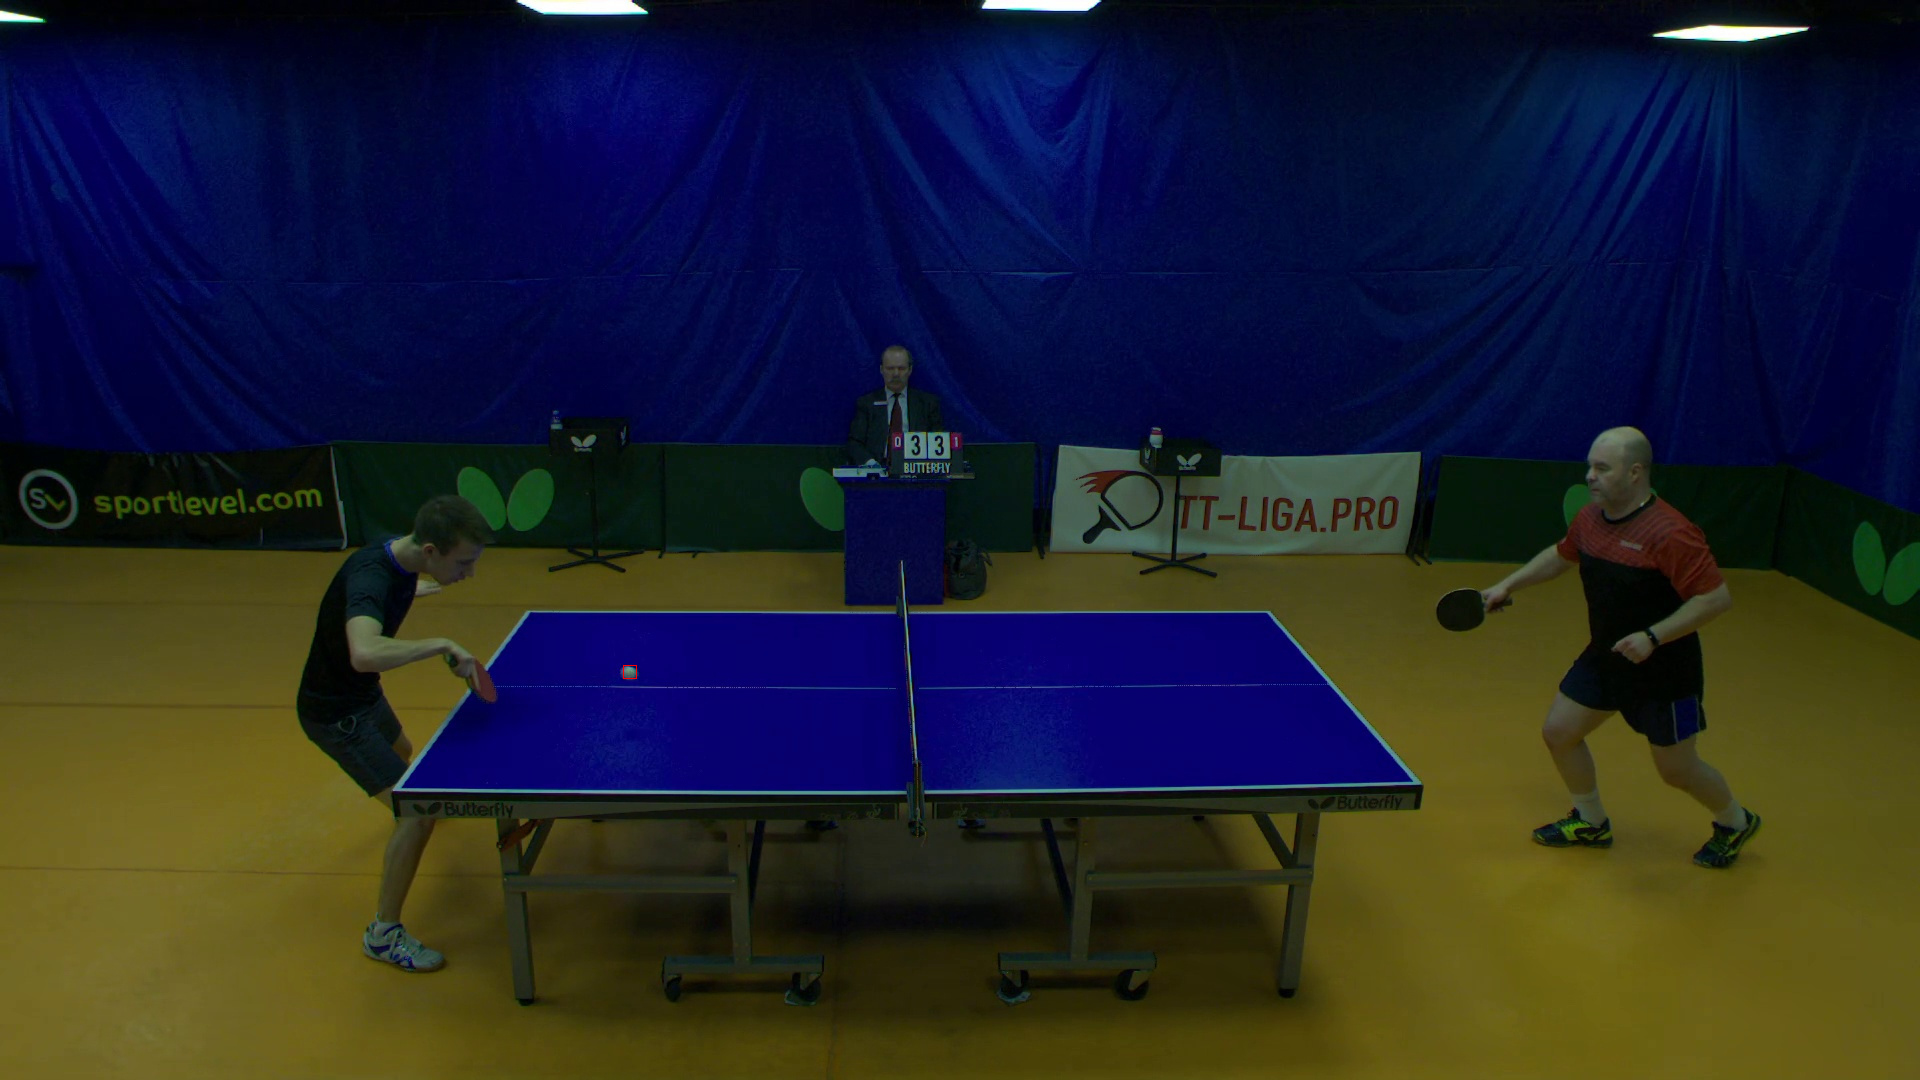

In [105]:
draw = ImageDraw.Draw(vsample)
for box in out_bbox:
    draw.rectangle(list(box), fill = None, outline="red")
vsample

In [148]:
def iou(x1a,y1a,x2a,y2a,x1b,y1b,x2b,y2b):

    x_intersection = max(0, min(x2a, x2b) - max(x1a,x1b))
    y_intersection = max(0, min(y2a, y2b) - max(y1a,y1b))
    intersection = x_intersection * y_intersection

    rect_a_area = (x2a - x1a) * (y2a - y1a)
    rect_b_area = (x2b - x1b) * (y2b - y1b)
    union = rect_a_area + rect_b_area - intersection
    return intersection / union

output


[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}]

In [149]:
# output[0]['boxes'][0].tolist()

iou_sum = 0

for i in range(0,1):
    img = data1[i][0]
    boxes = data1[i][1]["boxes"][0].tolist()

    output = model([img.to(device)])

    out_bbox = output[0]["boxes"][0].tolist()


    iou_sum += iou(boxes[0],boxes[1],boxes[2],boxes[3],out_bbox[0],out_bbox[1],out_bbox[2],out_bbox[3])
    print(iou_sum)


0.8111798986130906
